In [1]:
import os
os.getcwd()

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [4]:
!cp /mydrive/Yolov3/img.zip ./

In [ ]:
!unzip ./img.zip -d ./img

Streaming output truncated to the last 5000 lines.
  inflating: ./img/img/hard_hat_workers3248.txt  
  inflating: ./img/img/hard_hat_workers3249.png  
  inflating: ./img/img/hard_hat_workers3249.txt  
  inflating: ./img/img/hard_hat_workers325.png  
  inflating: ./img/img/hard_hat_workers325.txt  
  inflating: ./img/img/hard_hat_workers3250.png  
  inflating: ./img/img/hard_hat_workers3250.txt  
  inflating: ./img/img/hard_hat_workers3251.png  
  inflating: ./img/img/hard_hat_workers3251.txt  
  inflating: ./img/img/hard_hat_workers3252.png  
  inflating: ./img/img/hard_hat_workers3252.txt  
  inflating: ./img/img/hard_hat_workers3253.png  
  inflating: ./img/img/hard_hat_workers3253.txt  
  inflating: ./img/img/hard_hat_workers3254.png  
  inflating: ./img/img/hard_hat_workers3254.txt  
  inflating: ./img/img/hard_hat_workers3255.png  
  inflating: ./img/img/hard_hat_workers3255.txt  
  inflating: ./img/img/hard_hat_workers3256.png  
  inflating: ./img/img/hard_hat_workers3256.txt  
 

In [ ]:
!cp /mydrive/Yolov3/txtanno.zip ./

In [ ]:
!unzip ./txtanno.zip -d ./txt

Streaming output truncated to the last 5000 lines.
  inflating: ./txt/txtanno/hard_hat_workers1.txt  
  inflating: ./txt/txtanno/hard_hat_workers10.txt  
  inflating: ./txt/txtanno/hard_hat_workers100.txt  
  inflating: ./txt/txtanno/hard_hat_workers1000.txt  
  inflating: ./txt/txtanno/hard_hat_workers1001.txt  
  inflating: ./txt/txtanno/hard_hat_workers1002.txt  
  inflating: ./txt/txtanno/hard_hat_workers1003.txt  
  inflating: ./txt/txtanno/hard_hat_workers1004.txt  
  inflating: ./txt/txtanno/hard_hat_workers1005.txt  
  inflating: ./txt/txtanno/hard_hat_workers1006.txt  
  inflating: ./txt/txtanno/hard_hat_workers1007.txt  
  inflating: ./txt/txtanno/hard_hat_workers1008.txt  
  inflating: ./txt/txtanno/hard_hat_workers1009.txt  
  inflating: ./txt/txtanno/hard_hat_workers101.txt  
  inflating: ./txt/txtanno/hard_hat_workers1010.txt  
  inflating: ./txt/txtanno/hard_hat_workers1011.txt  
  inflating: ./txt/txtanno/hard_hat_workers1012.txt  
  inflating: ./txt/txtanno/hard_hat_wo

In [5]:
txtfolder = "./txt/txtanno/"
imagefolder = "./img/img"
image_size = 415
image_labels = ["head","person","helmet"]

In [6]:
import torch
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from xml.dom.minidom import parse


In [7]:
!pwd

/content


Half of the data will not be used for any purpose

In [8]:
import glob
total_image_count = len(glob.glob(f"{imagefolder}/*.png"))
train_image_count = int(total_image_count*0.4)
test_image_count = int(total_image_count*0.1)
train_image_count,test_image_count


(2000, 500)

In [15]:
import glob
import numpy
import os

class ImagesWithTxtDataset(torch.utils.data.Dataset):
    
    def __init__(self, is_train, folder,transforms=None):
        self.folder = folder
        
        if is_train == True:
          self.images = np.array(list(sorted(glob.glob(f"{folder}/*.png"))))[0:train_image_count]
        else:
          self.images = np.array(list(sorted(glob.glob(f"{folder}/*.png"))))[train_image_count:train_image_count+test_image_count]

        self.transforms = transforms
        
        
    def __getitem__(self, idx):

        # get image PIL format
        img_name = self.images[idx]
        img_path = img_name
        img = Image.open(img_path).convert("RGB")

        # get txt info
        image_base_name = os.path.basename(img_path)
        txt_path = txtfolder + image_base_name.split(".")[0]+".txt"
        file = open(txt_path,"r")

        boxes = []
        labels = []
        crowd_len = 0

        for line in file.readlines():
            crowd_len +=1

            # real image size will be replaced with image_size
            words = line.split(" ")
            class_str = words[0]
            class_int = image_labels.index(class_str)
            class_int +=1 #0 as for nothing

            x_min = np.float(words[1])
            y_min = np.float(words[2])
            x_max = np.float(words[3])
            y_max = np.float(words[4])

            
            
            a = [x_min,y_min,x_max,y_max]

            boxes.append(a)
            
            labels.append(class_int)
        
        boxes = np.array(boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.as_tensor(labels, dtype=torch.int64)      
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((crowd_len,), dtype=torch.int64)

        target = {
        }
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        
        if self.transforms is not None:
            img = self.transforms(img)
           
       
        
        return img,target
        
    
    def __len__(self):
        return len(self.images)

In [37]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
      
def get_object_detection_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Add one to num_classes as a index assigned for nothing
    num_classes = num_classes+1
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    return model

In [38]:
model = get_object_detection_model((len(image_labels)))
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=4, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=16, bias=True)
  )
)

# Get Dataset

In [18]:
data_transforms = transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])

train_dataset = ImagesWithTxtDataset(True,imagefolder,data_transforms)
test_dataset = ImagesWithTxtDataset(False,imagefolder,data_transforms)
len(train_dataset),len(test_dataset)

(2000, 500)

Test one image in Dataset

In [19]:
for i in range(len(train_dataset)):
  image1 = train_dataset[20][0]
  target1 = train_dataset[20][1]['boxes']
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


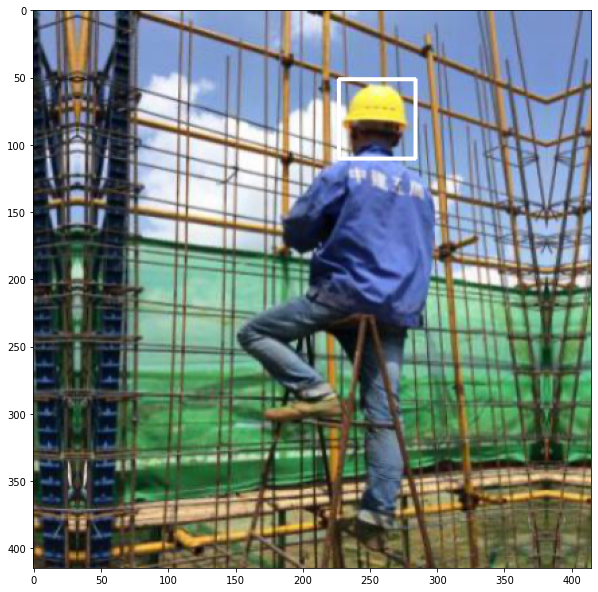

In [20]:
np_image = np.array(image1).transpose((1,2,0))
boxes = np.array(target1)

cv_image = cv2.cvtColor(np_image,cv2.COLOR_RGB2BGR)

for start_x,start_y,end_x,end_y in boxes:
  cv2.rectangle(cv_image, (start_x, start_y), (end_x, end_y), (255,255,255), 2)

from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
plt_image = cv2.cvtColor(cv_image,cv2.COLOR_BGR2RGB)
plt.imshow(plt_image)

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True,collate_fn=collate_fn)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=True,collate_fn=collate_fn)

In [40]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [41]:
params = [p for p in model.parameters() if p.requires_grad]

# SGD
optimizer = torch.optim.SGD(params, lr=0.0003,
                            momentum=0.9, weight_decay=0.0005)
num_epochs = 15

lr_scheduler = None

In [42]:
def evaluate(model,test_data_loader):
 #test evaluation
  with torch.no_grad():
    test_loss_history = []
    for images,targets in test_data_loader:   
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      test_loss_history.append(loss_value)
    
    loss_mean_test = sum(test_loss_history)/len(test_loss_history)
    return loss_mean_test



In [43]:
loss_hist = []

itr = 0

for epoch in range(num_epochs):
    
    loss_epoch = []
    for images, targets in train_data_loader:
           
        model.train()
    
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
       
        
        loss_dict = model(images, targets)
        
       
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        if itr % 50 == 0:
            print("loss_value",loss_value)
        itr+=1
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        

    #trainin evaluation    
    loss_mean_train = sum(loss_epoch) / len(loss_epoch)
    
    #test evaluation
    loss_mean_test = evaluate(model,test_data_loader)

    #history dictionary
    epoch_hist = {'train_loss:':loss_mean_train, 'test_loss':loss_mean_test}

    #append as dict ([] should have been not  used as causes to have 3 dimensional array )
    loss_hist.append([epoch_hist])

    print(f"train loss: {loss_mean_train}, test loss: {loss_mean_test} on epoch [{epoch}]")
    
  

    #print(f"Epoch #{epoch} loss: {loss_hist.value}")

loss_value 1.7286216020584106
loss_value 1.0331674814224243
loss_value 0.5884271860122681
loss_value 0.48985666036605835
loss_value 0.510468065738678
train loss: 0.735270033955574, test loss: 0.49828364688252647 on epoch [0]
loss_value 0.5556336045265198
loss_value 0.5021917223930359
loss_value 0.46777671575546265
loss_value 0.5041823387145996
loss_value 0.6558791399002075
train loss: 0.47885959470272066, test loss: 0.40933117436038124 on epoch [1]
loss_value 0.2816043496131897
loss_value 0.3563723862171173
loss_value 0.3710690438747406
loss_value 0.3313872516155243
loss_value 0.5660160183906555
train loss: 0.41943441599607467, test loss: 0.3853496282346665 on epoch [2]
loss_value 0.4616977274417877
loss_value 0.26082324981689453
loss_value 0.29621759057044983
loss_value 0.4066970646381378
loss_value 0.43859997391700745
train loss: 0.3971460362076759, test loss: 0.37265040666337995 on epoch [3]
loss_value 0.4386347830295563
loss_value 0.34619614481925964
loss_value 0.46983352303504944


# Loss Visualization

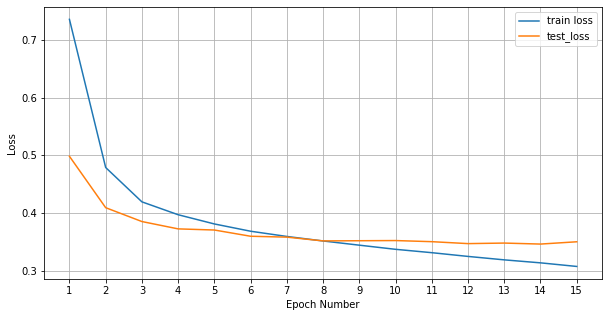

In [69]:
def plot_losses(train_loss,test_loss):
  plt.plot(train_loss, label = 'train loss')
  plt.plot(test_loss, label = 'test_loss')
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.legend()
  plt.xticks(np.arange(num_epochs), np.arange(1, num_epochs+1))
  plt.grid()
  plt.show()

train_loss = [i[0]['train_loss:'] for i in loss_hist]
test_loss = [i[0]['test_loss'] for i in loss_hist]


from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plot_losses(train_loss,test_loss)


# Functions For Optimizing and Visualising Model Predictions

Prediction Function takes PIL image transforming, and processing result array

In [70]:
def predict(model,image,threshold):
  model.eval()
  transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
    
  ])

  image = transform(image).to(device)
  image = image.unsqueeze(0) # add a batch dimension

  outputs = model(image)
  
  


  # 0 represent nothing, so index starts at 0
  # returns class name and class index as array of tuples
  predict_classes = outputs[0]['labels'].cpu().numpy()

  # get score for all the predicted objects
  #scores are sorted by order, so first n boxes are important for us
  predict_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
  boxes = outputs[0]['boxes'].detach().cpu().numpy()
  
  scores_bigger_than_threshold = predict_scores >= threshold
  predict_boxes = boxes[scores_bigger_than_threshold].astype(np.int32)
  

  return image[0], predict_boxes, predict_classes[:len(predict_boxes)], predict_scores[:len(predict_boxes)]


My Non Max Suppression Function for MultiLabel Object Detection

In [71]:


def nms(bounding_boxes, confidence_score, labels, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return []


    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # labels
    labels = np.array(labels)

    
    # Picked bounding boxes
    picked_boxes = []
    picked_score = []
    picked_labels = []

    unique_labels = np.unique(labels)

    mask = [labels == i for i in unique_labels]

    iterator = 0

    for m in mask:
      
      sub_boxes = boxes[m]
      sub_score = score[m]

     

      # coordinates of bounding boxes
      start_x = sub_boxes[:, 0]
      start_y = sub_boxes[:, 1]
      end_x = sub_boxes[:, 2]
      end_y = sub_boxes[:, 3]

      


      # Compute areas of bounding boxes
      areas = (end_x - start_x + 1) * (end_y - start_y + 1)
    

      # Sort by confidence score of bounding boxes
      order = np.argsort(sub_score)
      

      # Iterate bounding boxes
      while order.size > 0:
          # The index of largest confidence score
          index = order[-1]

        

          # Pick the bounding box with largest confidence score
          picked_boxes.append(sub_boxes[index])
          picked_score.append(sub_score[index])
          picked_labels.append(unique_labels[iterator])

          

          # Compute ordinates of intersection-over-union(IOU)
          #x1 returns max of n-1 x1 as it brodcast find max one by one
          x1 = np.maximum(start_x[index], start_x[order[:-1]])
          x2 = np.minimum(end_x[index], end_x[order[:-1]])
          y1 = np.maximum(start_y[index], start_y[order[:-1]])
          y2 = np.minimum(end_y[index], end_y[order[:-1]])

          # Compute areas of intersection-over-union
          w = np.maximum(0.0, x2 - x1 + 1)
          h = np.maximum(0.0, y2 - y1 + 1)
          intersection = w * h

          

          # Compute the ratio between intersection and union
          ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

          left = np.where(ratio < threshold)

          # continue with those who are not so close to main frame.
          order = order[left]
      
      # color loop
      iterator+=1

    return picked_boxes, picked_score, picked_labels

Draw Bounding Box to show results to user

In [72]:
COLORS = np.random.uniform(0, 255, size=(len(image_labels)+1, 3))

def draw_bounding_box(image,bounding_boxes,confidence_score,label):


  open_cv_image = numpy.array(image) 
  # Convert RGB to BGR 
  image = open_cv_image[:, :, ::-1].copy() 

  print("image shape : ",image.shape)

  # Draw parameters
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.3
  thickness = 1
  
  for index,((start_x, start_y, end_x, end_y), confidence) in enumerate(zip(bounding_boxes, confidence_score)):

      print("confidence : ",confidence," rectangle :",(start_x,start_y)," ",(end_x, end_y))
      (w, h), baseline = cv2.getTextSize(str(image_labels[label[index]-1]), font, font_scale, thickness)
      cv2.rectangle(image, (start_x, start_y - (2 * baseline + 5)), (start_x + w, start_y), (22,93,0), -1)
      
      cv2.rectangle(image, (start_x, start_y), (end_x, end_y), COLORS[label[index]], 2)
    
      cv2.putText(image, str(image_labels[label[index]-1]), (start_x, start_y), font, font_scale, (0, 0, 0), thickness)
  
  return image

# Test with user input image

In [74]:
sample_img = "hard_hat_workers1349.png"
sample_path1 = imagefolder + "/" + sample_img

img = Image.open(sample_path1).convert("RGB") 
image, boxes, classes, scores = predict(model,img, 0.4)
boxes,classes, scores

(array([[ 70, 148, 102, 187],
        [307, 138, 347, 187],
        [ 71,   0, 103,  15],
        [305,   0, 349,  25],
        [239, 169, 257, 194],
        [186, 150, 218, 188],
        [145, 162, 171, 198],
        [272, 167, 286, 184],
        [187,   0, 221,  14],
        [351, 158, 365, 178],
        [224, 161, 236, 179],
        [261, 162, 273, 183],
        [293, 159, 307, 178],
        [174, 160, 189, 184]], dtype=int32),
 array([3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.9983038 , 0.9978968 , 0.99584156, 0.99379903, 0.9923288 ,
        0.9808245 , 0.97730005, 0.96867293, 0.9628858 , 0.9254998 ,
        0.91438913, 0.90308887, 0.8834714 , 0.40170604], dtype=float32))

In [75]:
picked_boxes, picked_score, picked_labels = nms(boxes,scores,classes,0.4)
picked_boxes, picked_score,picked_labels

([array([239, 169, 257, 194], dtype=int32),
  array([186, 150, 218, 188], dtype=int32),
  array([145, 162, 171, 198], dtype=int32),
  array([272, 167, 286, 184], dtype=int32),
  array([187,   0, 221,  14], dtype=int32),
  array([351, 158, 365, 178], dtype=int32),
  array([224, 161, 236, 179], dtype=int32),
  array([261, 162, 273, 183], dtype=int32),
  array([293, 159, 307, 178], dtype=int32),
  array([174, 160, 189, 184], dtype=int32),
  array([ 70, 148, 102, 187], dtype=int32),
  array([307, 138, 347, 187], dtype=int32),
  array([ 71,   0, 103,  15], dtype=int32),
  array([305,   0, 349,  25], dtype=int32)],
 [0.9923288,
  0.9808245,
  0.97730005,
  0.96867293,
  0.9628858,
  0.9254998,
  0.91438913,
  0.90308887,
  0.8834714,
  0.40170604,
  0.9983038,
  0.9978968,
  0.99584156,
  0.99379903],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape :  (415, 415, 3)
confidence :  0.9923288  rectangle : (239, 169)   (257, 194)
confidence :  0.9808245  rectangle : (186, 150)   (218, 188)
confidence :  0.97730005  rectangle : (145, 162)   (171, 198)
confidence :  0.96867293  rectangle : (272, 167)   (286, 184)
confidence :  0.9628858  rectangle : (187, 0)   (221, 14)
confidence :  0.9254998  rectangle : (351, 158)   (365, 178)
confidence :  0.91438913  rectangle : (224, 161)   (236, 179)
confidence :  0.90308887  rectangle : (261, 162)   (273, 183)
confidence :  0.8834714  rectangle : (293, 159)   (307, 178)
confidence :  0.40170604  rectangle : (174, 160)   (189, 184)
confidence :  0.9983038  rectangle : (70, 148)   (102, 187)
confidence :  0.9978968  rectangle : (307, 138)   (347, 187)
confidence :  0.99584156  rectangle : (71, 0)   (103, 15)
confidence :  0.99379903  rectangle : (305, 0)   (349, 25)


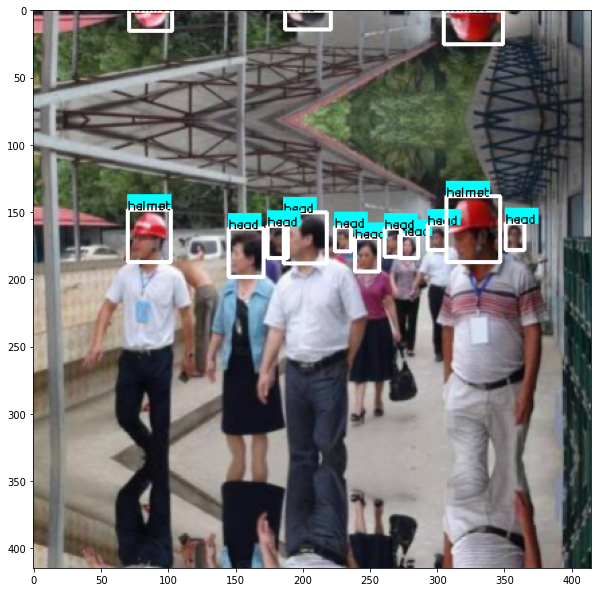

In [76]:
# used image that has been transformed for prediction. It is returned from predict function
np_predicted_image = image.to("cpu").numpy().transpose((1,2,0))
final_cv2_image = draw_bounding_box(np_predicted_image,picked_boxes, picked_score,picked_labels)

final_plt_image = cv2.cvtColor(final_cv2_image,cv2.COLOR_BGR2RGB)

from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
plt.imshow(final_plt_image)

In [77]:
torch.save(model, "./rcnn_model")